# Análisis de las ventas de cerveza en una cadena de supermercados

## Descripción del problema

En el siguiente análisis vamos a estudiar las ventas de cervezas en una cadena de supermercados durante el mes de Junio de 2018. Para ello contamos con dos ficheros de entrada:

* `master_articles.h5`: contiene la información del maestro de articulos. Tiene los siguientes campos:
 * `Articulo_Codigo` : identificador único del artículo
 * `Articulo_Nombre` : nombre del articulo
 * `GVSV`: categoría a la que pertenece el artículo (cervezas, bebidas refrescantes, café, etc.)
* `beer_sales.h5`: contiene todos los tickets de venta de cervezas (a nivel de línea de ticket). Tiene los siguientes campos:
 * `articulo`: identificador único del artículo comprado
 * `cantidad`: unidades compradas de ese artículo en el ticket
 * `importe`: importe en euros de ese artículo en el ticket
 * `tienda`: identificador único de la tienda donde se produjo la linea de ticket
 * `caja`: identificador de la caja registradora en la que se produjo la linea de ticket
 * `dia`: dia en el que se produjo la linea de ticket
 * `hora`: hora en la que se produjo la linea de ticket
 * `minuto`: minuto en el que se produjo la linea de ticket
 * `ticket`: identificador NO único del ticket (es un identificador del ticket por tienda y caja)

## Desarrollo de la solución

### Configuración del entorno y librerias

In [1]:
#!pip install prophet

In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import datetime
import math
from scipy import stats
import seaborn as sns

#Import para los modelos
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.model_selection import train_test_split
from timeit import default_timer

from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler

from prophet import Prophet

import warnings
warnings.filterwarnings("ignore")

matplotlib.rcParams.update({'font.size': 14})


### En primer lugar, nos gustaría traernos el nombre de cada artículo al dataset de tickets.

In [3]:
master_data=pd.read_hdf('master_articles.h5')
master_data.sample(7)

,Articulo_Codigo,Articulo_Nombre,GVSV
55097,76864,PECHUGA PAVO S&MOTA TACOS2X50G,6302
58688,85543,CEBOLLA FRITA MAR ESPEC B/200G,7101
39350,76740,ARRIAUNDI CROISSANT MINI CHOCO,7302
41925,79596,ACEITE F.DE MAYO MUSGO 200ML,8410
55535,82499,TTO.R.DUERO A.TAMARON RES 3/4L,6735
11266,29919,PERCHA ABRIGOS ADHESIVA 8 CM,1001
556,7562,"CACAO GERBLE ESP.OSEO,420 G",4910


In [4]:
master_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60837 entries, 0 to 60836
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Articulo_Codigo  60837 non-null  int64 
 1   Articulo_Nombre  60837 non-null  object
 2   GVSV             60837 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


In [5]:
master_data[master_data['Articulo_Codigo']==7607]

,Articulo_Codigo,Articulo_Nombre,GVSV
45567,7607,ESTR.GALICIA 8+2,5802


In [6]:
master_data.GVSV.value_counts()

2501    4127
8402    1467
1001    1427
1201    1328
1204    1298
        ... 
7999       1
8803       1
7599       1
8206       1
9601       1
Name: GVSV, Length: 499, dtype: int64

In [7]:
beer_sales_data=pd.read_hdf('beer_sales.h5')
beer_sales_data.sample(7)

,articulo,caja,cantidad,dia,hora,importe,minuto,ticket,tienda
21137,45895,2,4.0,7,15,2.28,59,185,14966
21301,11213,4,8.0,23,11,3.18,28,53,14026
40996,14920,3,8.0,6,9,4.48,14,15,14315
28450,7643,3,4.0,9,13,2.52,44,63,14739
30538,7571,2,4.0,14,20,2.60,55,456,14821
23422,8124,3,3.0,9,9,1.02,51,34,14523
24520,11213,5,7.0,9,11,3.71,20,88,14073


In [8]:
beer_sales_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45835 entries, 0 to 45834
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   articulo  45835 non-null  int64  
 1   caja      45835 non-null  object 
 2   cantidad  45835 non-null  float64
 3   dia       45835 non-null  object 
 4   hora      45835 non-null  object 
 5   importe   45835 non-null  float64
 6   minuto    45835 non-null  object 
 7   ticket    45835 non-null  object 
 8   tienda    45835 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 3.5+ MB


In [9]:
beer_sales_data.tienda.value_counts()

14315    781
14314    778
14311    748
14093    620
14083    546
        ... 
14972      6
14974      5
14971      4
14976      3
14978      2
Name: tienda, Length: 228, dtype: int64

In [10]:
master_data_temp=master_data.pop('GVSV')
beer_sales_name_data = beer_sales_data.join(master_data.set_index('Articulo_Codigo'), on='articulo')
beer_sales_name_data

,articulo,caja,cantidad,dia,hora,importe,minuto,ticket,tienda,Articulo_Nombre
0,19519,3,1.0,23,13,6.12,19,137,14808,SAN MIGUEL 12X33cl.
1,19519,3,1.0,29,11,6.12,52,78,14808,SAN MIGUEL 12X33cl.
2,7571,2,6.0,30,18,3.90,37,310,14967,ESTR.GALICIA 33cl.
3,8128,3,1.0,5,13,0.00,44,57,14214,MOLENBIER 33cl.
4,13340,3,1.0,5,13,0.00,44,57,14214,SKOL 33cl.
...,...,...,...,...,...,...,...,...,...,...
45830,12814,2,8.0,6,11,4.96,25,84,14217,MAHOU 5 EST 33cl.
45831,8767,3,1.0,9,11,7.56,34,26,14217,MAHOU 5 EST 12LX33cl.
45832,45569,2,1.0,14,18,8.45,6,254,14217,MAHOU 5 EST 18LX33cl.
45833,52527,2,8.0,27,12,4.08,34,102,14217,CRUZCAMPO 33cl.


In [11]:
beer_sales_name_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45835 entries, 0 to 45834
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   articulo         45835 non-null  int64  
 1   caja             45835 non-null  object 
 2   cantidad         45835 non-null  float64
 3   dia              45835 non-null  object 
 4   hora             45835 non-null  object 
 5   importe          45835 non-null  float64
 6   minuto           45835 non-null  object 
 7   ticket           45835 non-null  object 
 8   tienda           45835 non-null  int64  
 9   Articulo_Nombre  45835 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 3.8+ MB


### Como se ha explicado en la descripción del problema, el campo `ticket` del dataset de ventas no es único. Es decir, puede haber líneas de ticket que compartan valor de `ticket` sin pertenecer necesariamente al mismo ticket. Dada la información disponible, ¿se te ocurre alguna manera de generar un id de ticket que identifique unequívocamente las lineas que pertenecen a un mismo ticket?

* **Respuesta:** Tal como se indica al principio el ticket es por caja y tienda. Por lo que podría existir un mismo código de ticket para la misma tienda pero producido por distintas cajas, así como un mismo código de ticket generado en distintas tiendas. Por lo que la propuesta será generador el identificador único de ticket **uniendo tienda+dia+caja+ticket**. Entendiendo que los ticktes una vez generados ya no se repetien en la misma caja ningún tiempo despues el mismo día.

In [12]:
beer_sales_name_uniq_ticket_data = beer_sales_name_data.copy()
beer_sales_name_uniq_ticket_data['identificador_unico_ticket'] = beer_sales_name_uniq_ticket_data['tienda'].map(
    str)+'-'+beer_sales_name_uniq_ticket_data['dia']+'-'+beer_sales_name_uniq_ticket_data['caja'] + '-'+beer_sales_name_uniq_ticket_data['ticket']
beer_sales_name_uniq_ticket_data

,articulo,caja,cantidad,dia,hora,importe,minuto,ticket,tienda,Articulo_Nombre,identificador_unico_ticket
0,19519,3,1.0,23,13,6.12,19,137,14808,SAN MIGUEL 12X33cl.,14808-23-3-137
1,19519,3,1.0,29,11,6.12,52,78,14808,SAN MIGUEL 12X33cl.,14808-29-3-78
2,7571,2,6.0,30,18,3.90,37,310,14967,ESTR.GALICIA 33cl.,14967-30-2-310
3,8128,3,1.0,5,13,0.00,44,57,14214,MOLENBIER 33cl.,14214-5-3-57
4,13340,3,1.0,5,13,0.00,44,57,14214,SKOL 33cl.,14214-5-3-57
...,...,...,...,...,...,...,...,...,...,...,...
45830,12814,2,8.0,6,11,4.96,25,84,14217,MAHOU 5 EST 33cl.,14217-6-2-84
45831,8767,3,1.0,9,11,7.56,34,26,14217,MAHOU 5 EST 12LX33cl.,14217-9-3-26
45832,45569,2,1.0,14,18,8.45,6,254,14217,MAHOU 5 EST 18LX33cl.,14217-14-2-254
45833,52527,2,8.0,27,12,4.08,34,102,14217,CRUZCAMPO 33cl.,14217-27-2-102


### ¿Se te ocurre alguna manera de verificar que el identificador generado agrupa correctamente las líneas de ticket? ¿Qué consecuencias crees que podría tener el no generarlo correctamente?

* **Respuesta:**

In [13]:
#Hacemos una función que se aplique por apply fila y comprobamos que tienda+dia+caja+ticket es el mismo que el asignado.
def comprobar_ticket(row):
    correcto='N'
    id_ticket_temp=str(row['tienda'])+'-'+row['dia']+'-'+row['caja']+'-'+row['ticket']
    if  id_ticket_temp == row['identificador_unico_ticket']:
        correcto = 'Si'
    else:
        correcto = 'No'
    return correcto

In [14]:
beer_sales_name_uniq_ticket_data_test=beer_sales_name_uniq_ticket_data.copy()
beer_sales_name_uniq_ticket_data_test['id_ticket_correcto'] = beer_sales_name_uniq_ticket_data_test.apply(comprobar_ticket,axis=1)
beer_sales_name_uniq_ticket_data_test['id_ticket_correcto'].value_counts(normalize=True)*100

Si    100.0
Name: id_ticket_correcto, dtype: float64

* **Respuesta:**

* Las consecuencias de no generarlo bien irían, por ejemplo:
    * Contabilizar tickets de una tienda a otra, o directamente no saber de que tienda, si no se incluyera el campo tienda en el nuevo código, y solo tuvieramos en cuenta la caja y el dia y el número de ticket.
    * Se generarían códigos de ticket repetidos también si no se tuviera en cuenta el día y solo fuera tienda, caja y ticket. Por que una caja de una tienda determinada genera el ticket 1 todos los días.
    * Inclcuos el carater delimitador es necesario ya que se pueden dar combinaciones númericas de tienda, día, caja y ticket que siendo el mismo identificador de ticket, corresponden a comprar realizadas en distintos días. Por ejemplo imagen adjunta.
    
    <img src="ejemplo_codigo_mal_generado.PNG" style="width: 800px">
    

### Ahora, nos gustaría ver en un gráfico las ventas por articulo del TOP 10 de cervezas más vendidas.

In [15]:
def plot_beer_sales(df,title=None,x_label=None,y_label=None,legend_label=None):
    
# Obtenemos las columnas a representar.

    color_scale = plt.get_cmap('Paired')
    
    sales = df.iloc[:,1]
    beers_types = df.iloc[:,0]
    color_list=[]
    for i in range(0,len(beers_types)):
        color_list.append(color_scale(i))
    
      # Instanciamos la figura.
    fig, ax = plt.subplots(figsize=(16, 7))
    
    # Representamos las líneas.
    width = 0.65
    ax.bar(beers_types, sales, width, color=color_list)
    
    ax.set_xticks(beers_types)
    ax.set_xticklabels(beers_types, rotation=35, ha='right')
        
 # Añadimos unas guías verticales.
    ax.grid(True, axis='y')
    
 # Ocultamos el marco.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
 #  ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
 # Etiquetamos el eje X.
    ax.set_ylabel('Número de unidades')
    ax.set_xlabel('Tipos de Cervezas')
     
    for index,data in enumerate(sales):
        ax.text(x=index,y=data, s="%d\n"%(data) , ha='center', va='bottom' ,fontdict=dict(fontsize=14))
        
    fig.suptitle(title, y=.925); 
    return fig, ax

In [16]:
top_10_by_cantidad = beer_sales_name_uniq_ticket_data.groupby(
    by='Articulo_Nombre', as_index=False)['cantidad'].agg('sum').sort_values(by='cantidad', ascending=False).head(10)
top_10_by_cantidad

,Articulo_Nombre,cantidad
27,SAN MIGUEL 33cl.,59493.0
12,HEINEKEN 33cl.,27120.0
24,MOLENBIER 33cl.,26989.0
16,KELER LUXE 33cl.,23352.0
19,MAHOU 5 EST 33cl.,19045.0
9,ESTR.GALICIA 33cl.,14916.0
4,AMSTEL CLASICA 33cl.,11498.0
22,MAHOU CLASICA 33cl.,10569.0
2,AMSTEL 33cl.,8944.0
10,ESTRELLA DAMM 33cl.,4994.0


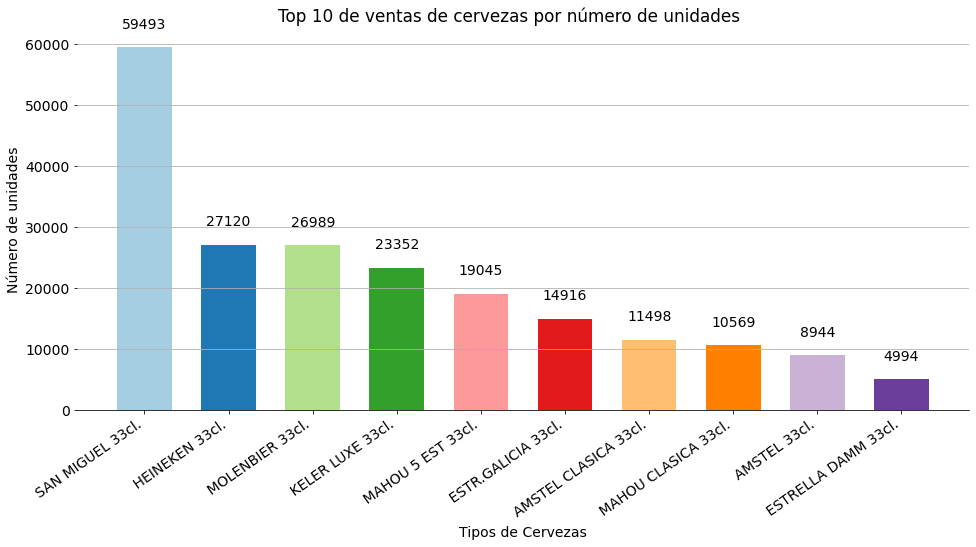

In [17]:
plot_beer_sales(top_10_by_cantidad,title='Top 10 de ventas de cervezas por número de unidades');

In [18]:
top_10_by_ticket = beer_sales_name_uniq_ticket_data.groupby(
    by='Articulo_Nombre', as_index=False)['ticket'].agg('count').sort_values(by='ticket', ascending=False).head(10)
top_10_by_ticket

,Articulo_Nombre,ticket
27,SAN MIGUEL 33cl.,8369
24,MOLENBIER 33cl.,6552
12,HEINEKEN 33cl.,4160
16,KELER LUXE 33cl.,3618
29,SKOL 33cl.,2737
9,ESTR.GALICIA 33cl.,2685
19,MAHOU 5 EST 33cl.,2654
8,ESTR.GALICIA 8+2,1978
22,MAHOU CLASICA 33cl.,1700
2,AMSTEL 33cl.,1460


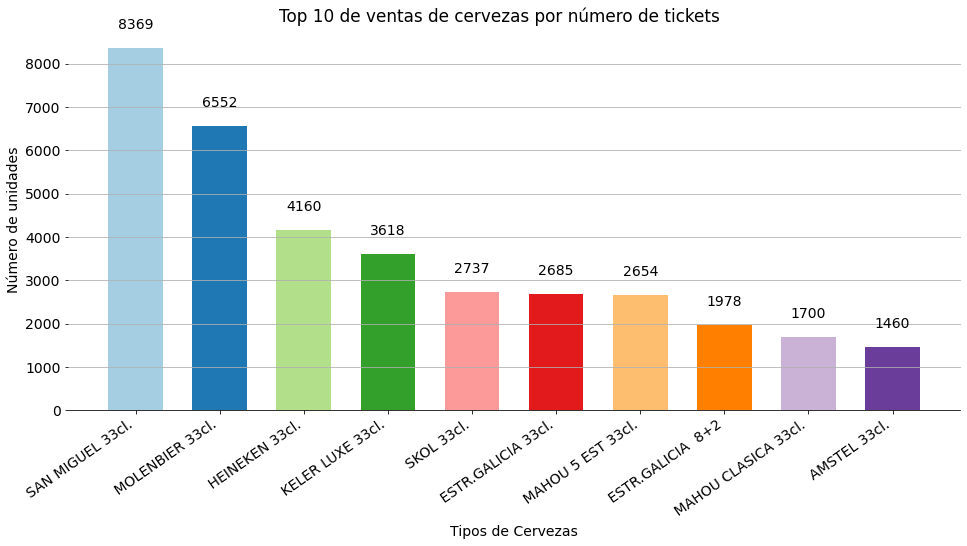

In [19]:
plot_beer_sales(top_10_by_ticket,title='Top 10 de ventas de cervezas por número de tickets');

### Se han detectado una serie de tickets anómalos en los que la cantidad de cervezas compradas es extremadamente alto. ¿Como harías para detectarlos y filtrarlos de nuestro conjunto de ventas?

* **Respuesta:** Esto es un ejemplo de detección de outliers que pueden distorsionar los calculos de valor medio del tcket, ventas medias o agragadas, ...,etc. Para ello vamos a aplicar Tukey para detectarlos y eliminarlos.

In [20]:
def filtrar_outlier_tukey(x):
    # Función que implementa Tukey para la eliminación de outliers
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    iqr = q3 - q1 
#     print("[q1=%f, q3=%f, iqr=%f]" % (q1, q3, iqr))
    
    floor = q1 - 1.5*iqr
    ceiling = q3 + 1.5*iqr
#     print("[floor=%f, ceiling=%f]" % (floor, ceiling))
    
    outlier_indices = list(x.index[(x < floor)|(x > ceiling)])
    outlier_values = list(x[outlier_indices])

    return outlier_indices, outlier_values

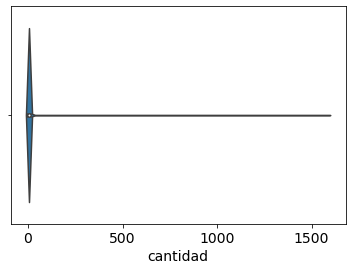

In [21]:
beer_sales_name_uniq_ticket_data_outliers=beer_sales_name_uniq_ticket_data.copy()
beer_sales_name_uniq_ticket_data_outliers=beer_sales_name_uniq_ticket_data_outliers.loc[:,['identificador_unico_ticket','cantidad']]

#Usamos Seaborn que los violines salen más bonitos.

# sns.set_theme(style="whitegrid", palette="pastel")
ax = sns.violinplot(x=beer_sales_name_uniq_ticket_data_outliers["cantidad"])

In [22]:
idx_outlier,_ = filtrar_outlier_tukey(beer_sales_name_uniq_ticket_data_outliers['cantidad'])
beer_sales_name_uniq_ticket_data_outliers.iloc[idx_outlier,:]

,identificador_unico_ticket,cantidad
9,14202-19-2-256,24.0
30,14838-11-3-245,16.0
118,14316-15-3-6,48.0
119,14316-27-2-57,18.0
161,14033-22-3-334,49.0
...,...,...
45751,14313-8-2-19,50.0
45805,14082-23-4-271,16.0
45821,14046-1-2-116,18.0
45824,14541-16-2-24,16.0


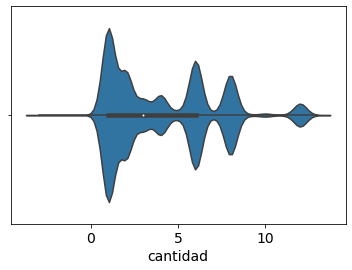

In [23]:
beer_sales_name_uniq_ticket_data_outliers=beer_sales_name_uniq_ticket_data_outliers.drop(idx_outlier,inplace=False)
ax = sns.violinplot(x=beer_sales_name_uniq_ticket_data_outliers["cantidad"])

### ¿Se te ocurre alguna manera de automáticamente detectar estos tickets en el futuro? ¿Y algún motivo de su presencia?

* **Respuesta:** Podemos usar una modelo no supervisado que nos ayuda a detectar anomalías. Este modelo es el **IsolationForest**. Para ello vamos a extraer del dataser la columna 'cantidad' y se le pasará al algoritmo.

In [24]:
beer_sales_name_uniq_ticket_data_outliers_2=beer_sales_name_uniq_ticket_data.copy()
beer_sales_name_uniq_ticket_data_outliers_2=beer_sales_name_uniq_ticket_data_outliers_2.loc[:,['identificador_unico_ticket','cantidad']]
X=beer_sales_name_uniq_ticket_data_outliers_2['cantidad'].values.reshape(-1, 1)
X

array([[1.],
       [1.],
       [6.],
       ...,
       [1.],
       [8.],
       [1.]])

In [25]:
#Entrenamos el modelo con los datos de cantidad.
from sklearn.ensemble import IsolationForest
iforest = IsolationForest(contamination=0.05)
iforest = iforest.fit(X)

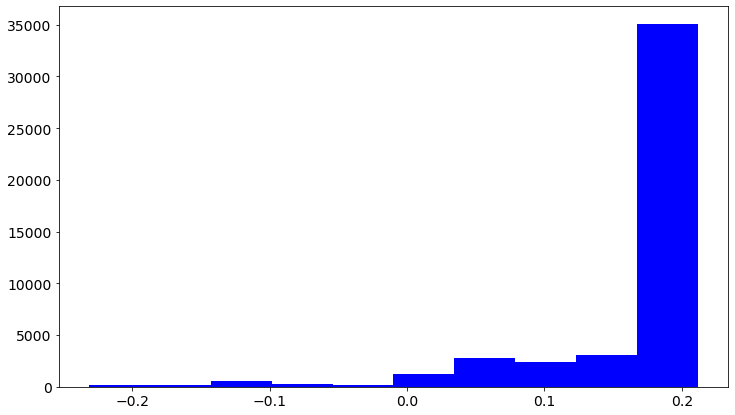

In [62]:
#Obteniendo la matriz de decisión vemos como se distribuyen los datos anómalos. Contra menor es el indicador de las X
# más outlier es el valor de cantidad.

iforest_X = iforest.decision_function(X)
plt.subplots(figsize=(12, 7))
plt.hist(iforest_X,facecolor='b')
plt.grid(False, axis='x')
plt.show();

In [27]:
#Los valores más fuera de rango se situan de los primeros. Por lo que vamos a extraer los 10 primeros outliers más relevantes.
X_outliers = beer_sales_name_uniq_ticket_data_outliers_2.iloc[np.argsort(iforest_X)[:10],:]
X_outliers

,identificador_unico_ticket,cantidad
3376,14807-27-2-8,360.0
11109,14056-29-2-32,288.0
36527,14056-15-2-37,1032.0
35198,14212-23-4-72,336.0
35197,14212-15-5-1,1596.0
11105,14056-21-3-2,336.0
24225,14065-15-2-160,360.0
36528,14056-20-3-46,360.0
11103,14056-15-2-45,672.0
11100,14056-8-2-32,264.0


In [28]:
#Comprobando en el dataset inicial vemos que efectivamente estos son dos outliers.
beer_sales_name_uniq_ticket_data.iloc[[35197,36527]]

,articulo,caja,cantidad,dia,hora,importe,minuto,ticket,tienda,Articulo_Nombre,identificador_unico_ticket
35197,8128,5,1596.0,15,12,399.00,35,1,14212,MOLENBIER 33cl.,14212-15-5-1
36527,11213,2,1032.0,15,9,402.48,49,37,14056,SAN MIGUEL 33cl.,14056-15-2-37


* Es muy posible que este tipo de *outliers* se generen al pasar por caja y por un error al teclear el número de unidades, se generen estas cantidades tan grandes.

### A continuación, nos gustaría analizar qué cervezas se compran juntas más a menudo. Para ello, a partir de los tickets, calcularemos el número de veces que se compran cada par de articulos conjuntamente (en el mismo ticket).

In [29]:
def busca_cervezas(row,col1,col2):
    cervezas=''
    num_cervezas=0
    index=row.index
    for i in index:
        if ((i==col1)|(i==col2)):
            pass
        elif(row.loc[i]>=1):
            cervezas=cervezas+'-'+i
            num_cervezas+=1
    row[col1]=cervezas
    row[col2]=num_cervezas
    
    return row

In [30]:
# aaa=beer_sales_name_uniq_ticket_data.groupby(by=['identificador_unico_ticket','articulo'],as_index=False)
beer_sales_name_uniq_ticket_pair_beer_data=beer_sales_name_uniq_ticket_data.loc[:,['identificador_unico_ticket','Articulo_Nombre']].sort_values(by='identificador_unico_ticket')
beer_sales_name_uniq_ticket_pair_beer_data = beer_sales_name_uniq_ticket_pair_beer_data.groupby(['identificador_unico_ticket', 'Articulo_Nombre']).size().unstack(fill_value=0)
beer_sales_name_uniq_ticket_pair_beer_data['cervezas']=np.nan
beer_sales_name_uniq_ticket_pair_beer_data['num_cervezas']=np.nan
beer_sales_name_uniq_ticket_pair_beer_data_2=beer_sales_name_uniq_ticket_pair_beer_data.apply(busca_cervezas,axis=1,col1='cervezas', col2='num_cervezas')

In [31]:
beer_sales_name_uniq_ticket_pair_beer_data_2

Articulo_Nombre,AMBAR ESP 9X33cl.,AMSTEL 12X33cl.,AMSTEL 33cl.,AMSTEL 50cl.,AMSTEL CLASICA 33cl.,AMSTEL EXTRA 33cl.,CRUZCAMPO 33cl.,CRUZCAMPO ESPECIAL L33cl.,ESTR.GALICIA 8+2,ESTR.GALICIA 33cl.,...,MAHOU CLASICA 33cl.,MAHOU S/GLUTEN 33cl.,MOLENBIER 33cl.,MOLENBIER100%MALT 33cl.,SAN MIGUEL 12X33cl.,SAN MIGUEL 33cl.,SAN MIGUEL 50cl.,SKOL 33cl.,cervezas,num_cervezas
identificador_unico_ticket,,,,,,,,,,,,,,,,,,,,,
14018-1-2-103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,- KELER LUXE 33cl.,1
14018-1-2-147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,- HEINEKEN 33cl.,1
14018-1-2-221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,- SAN MIGUEL 33cl.,1
14018-1-2-40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,- KELER LUXE 33cl.,1
14018-1-2-45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,- KELER LUXE 33cl.,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14982-5-1-2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,- ESTR.GALICIA 8+2,1
14982-5-1-8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,- MAHOU 5 EST 33cl.,1
14982-6-1-9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,- SAN MIGUEL 33cl.,1


In [32]:
def plot_pair_beers(df,color_scale):
    
    color_scale = plt.get_cmap(color_scale)
    
    # Obtenemos las columnas a representar.
    pair_beers = df.iloc[:,0]
    points = df.iloc[:,1]
    
    color_list=[]
    for i in range(0,len(pair_beers)):
        color_list.append(color_scale(i))
  
    # Instanciamos la figura.
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Añadimos unas guías verticales.
    ax.grid(True, axis='x')

    # Representamos las líneas.
    
    ax.barh(pair_beers, points, color=color_list)

    # Añadimos la leyenda.
#     ax.legend(handles=legend_entries)

    # Ocultamos el marco.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
#    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
#     # Etiquetamos el eje X.
    ax.set_xlabel('Veces seleccionadas')
  

    return fig, ax

In [33]:
beer_sales_name_uniq_ticket_pair_beer_data_2 = beer_sales_name_uniq_ticket_pair_beer_data_2[
    beer_sales_name_uniq_ticket_pair_beer_data_2['num_cervezas'] > 1]

beer_sales_name_uniq_ticket_pair_beer_data_3=pd.DataFrame(beer_sales_name_uniq_ticket_pair_beer_data_2['cervezas'].value_counts()[:10]).reset_index()

beer_sales_name_uniq_ticket_pair_beer_data_3

,index,cervezas
0,- MOLENBIER 33cl.- SKOL 33cl.,263
1,- SAN MIGUEL 33cl.- SAN MIGUEL 50cl.,88
2,- HEINEKEN 33cl.- SAN MIGUEL 33cl.,64
3,- MOLENBIER 33cl.- SAN MIGUEL 33cl.,57
4,- KELER LUXE 33cl.- SAN MIGUEL 33cl.,47
5,- MOLENBIER 33cl.- MOLENBIER100%MALT 33cl.,46
6,- HEINEKEN 33cl.- KELER LUXE 33cl.,44
7,- MAHOU 5 EST 33cl.- MAHOU CLASICA 33cl.,37
8,- ESTR.GALICIA 33cl.- MOLENBIER 33cl.,33
9,- ESTR.GALICIA 33cl.- SAN MIGUEL 33cl.,29


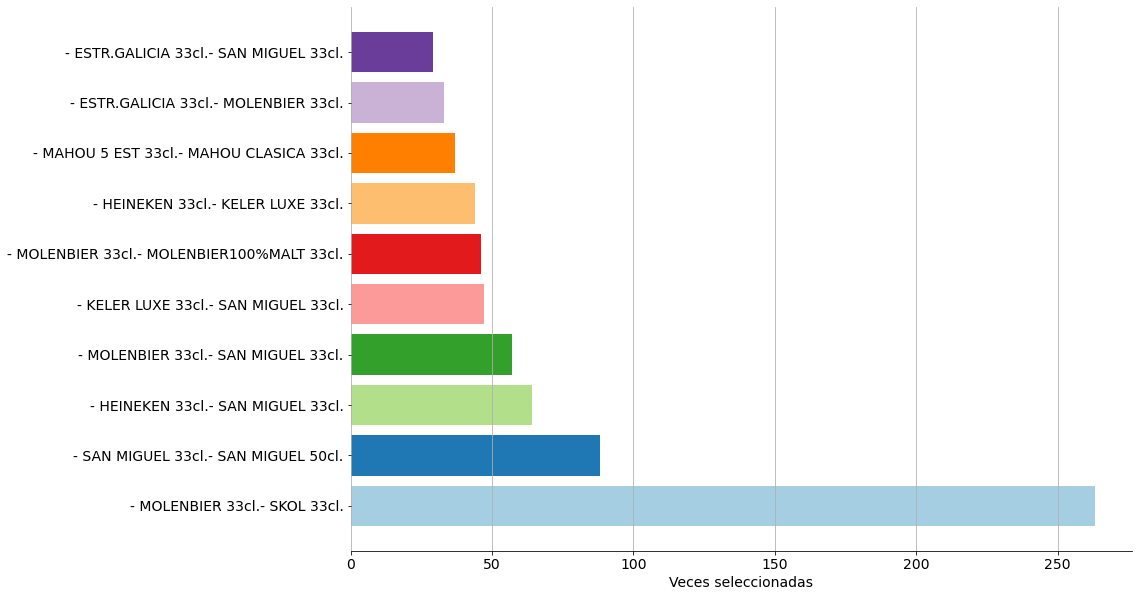

In [61]:
plot_pair_beers(beer_sales_name_uniq_ticket_pair_beer_data_3,'Paired');

### ¿Se te ocurre alguna posible manera de optimizar este cálculo?

### ¿Qué utilidad crees que puede tener esta información?

* Puede tener utilidad de cara a priorizar los stocks de las cervezas que se llevan en par.
* También a facilitar la colocación en la tienda para que esten cerca una de otras.
* Buscar ofertas conjuntas con los fabricantes de car a potenciar más esta tendencia.

### Nos gustaría ver como evoluciona la venta de cervezas a lo largo de la semana y por tramos horarios. ¿Podrías representar esto en un único gráfico? ¿Qué utilidad de negocio crees que tendría esta información segmentada?

* **Respuesta Gráfico:**

In [35]:
def grouped_bar_plot(
    df, amount_key, group_key, color_key, width=0.35, title=None, amount_title=None, group_title=None,
    color_title=None, rotate_x_labels=False, aggfunc='mean',palette='Blues', alternate_xlabel=None
):
    assert aggfunc in ('mean', 'sum')
    
    color_scale = plt.get_cmap(palette)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Ordenamos el DataFrame por la clave del grupo y del color.
    df = df.sort_values([group_key, color_key])

    # Obtenemos las etiquetas de los grupos.
    if alternate_xlabel:
        group_labels = df[alternate_xlabel].unique()
    else:
        group_labels = df[group_key].unique()
    
    # Calculamos el número de grupos.
    number_of_groups = group_labels.shape[0]
    
    # Calculamos el número de barras por grupo.
    number_of_bars_per_group = df[color_key].unique().shape[0]
    
    # Agrupamos el DataFrame de tal forma que solo haya un valor por cada par grupo-color.
    df = df.groupby([color_key, group_key])
    
    if aggfunc == 'mean':
        df = df.mean()
    elif aggfunc == 'sum':
        df = df.sum()
    
    # Calculamos la distancia entre los grupos.
    distance = width * (number_of_bars_per_group + 1)
    
    # Calculamos la posición de cada grupo en el eje X.
    group_x_possition = np.linspace(1, distance * number_of_groups, number_of_groups)
    
    #print(group_x_possition)
    
    # Creamos un DataFrame por cada color para iterarlo.
    df = df.groupby(color_key)
    
    # Iteramos los grupos y, en cada iteración, representamos todas las barras de un mismo color.
    for i, df_subset in enumerate(df):
        # Calculamos la posición relativa de la barra con respecto al grupo.
                
        relative_position = ((1 - number_of_bars_per_group)/2 + i) * width
        
        # Representamos las barras de un mismo color.
        ax.bar(
            group_x_possition + relative_position,
            df_subset[1][amount_key],
            width=width,
            color=color_scale((i+1)/number_of_bars_per_group),
            label=df_subset[1].index[0][0]
        )
    
    # Añadimos la leyenda.    
    ax.legend(bbox_to_anchor=(1.05, 1), title=color_title)

    # Etiquetamos la figura.
    fig.suptitle(title)

    ax.set_xticks(group_x_possition)
    if rotate_x_labels:
        ax.set_xticklabels(group_labels, rotation=30, ha='right')
    else:
        ax.set_xticklabels(group_labels)
        
    ax.set_ylabel(amount_title)
    ax.set_xlabel(group_title)

    # Mostramos la cuadricula.
    ax.grid(True, axis='y')

    # Ocultamos el marco.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
        
    return fig, ax

In [36]:
def establece_franja_horaria(row):
    franja=''
    hora= int(row.hora)
    if ((hora >=6)&(hora < 12)):
        franja = 'MA'
    elif ((hora >= 12)&(hora<15)):
        franja = 'MD'
    else:
        franja ='TA'
    return franja

In [37]:
beer_sales_name_uniq_ticket_time_data=beer_sales_name_uniq_ticket_data.copy()

In [38]:
beer_sales_name_uniq_ticket_time_data=beer_sales_name_uniq_ticket_time_data.groupby(['dia','hora'],as_index=False)['importe'].sum()

beer_sales_name_uniq_ticket_time_data['franja']=beer_sales_name_uniq_ticket_time_data.apply(establece_franja_horaria,axis=1)

beer_sales_name_uniq_ticket_time_data['fecha']=pd.to_datetime(dict(year='2018', month='06', 
                                                                    day=beer_sales_name_uniq_ticket_time_data['dia'],
                                                                    hour=beer_sales_name_uniq_ticket_time_data['hora'],
                                                                    minute='0'))

beer_sales_name_uniq_ticket_time_data['nombre_dia']=beer_sales_name_uniq_ticket_time_data['fecha'].dt.day_name()
beer_sales_name_uniq_ticket_time_data['numero_dia_en_semana']=beer_sales_name_uniq_ticket_time_data['fecha'].dt.dayofweek.sort_values()

beer_sales_name_uniq_ticket_time_data=beer_sales_name_uniq_ticket_time_data.groupby(by=['nombre_dia','numero_dia_en_semana','franja'])['importe'].mean()
beer_sales_name_uniq_ticket_time_data=beer_sales_name_uniq_ticket_time_data.reset_index()

new_map_day={'Monday':'Lunes', 'Tuesday':'Martes', 'Wednesday':'Miércoles', 'Thursday':'Jueves','Friday':'Viernes','Saturday':'Sábado','Sunday':'Domingo'}
beer_sales_name_uniq_ticket_time_data['nombre_dia'] = beer_sales_name_uniq_ticket_time_data['nombre_dia'].map(new_map_day)
beer_sales_name_uniq_ticket_time_data.sort_values('numero_dia_en_semana')


,nombre_dia,numero_dia_en_semana,franja,importe
3,Lunes,0,MA,352.003077
4,Lunes,0,MD,458.920833
5,Lunes,0,TA,354.432069
17,Martes,1,TA,315.587586
16,Martes,1,MD,420.931667
15,Martes,1,MA,294.452500
20,Miércoles,2,TA,358.599286
18,Miércoles,2,MA,269.270000
19,Miércoles,2,MD,466.071667
14,Jueves,3,TA,373.930000


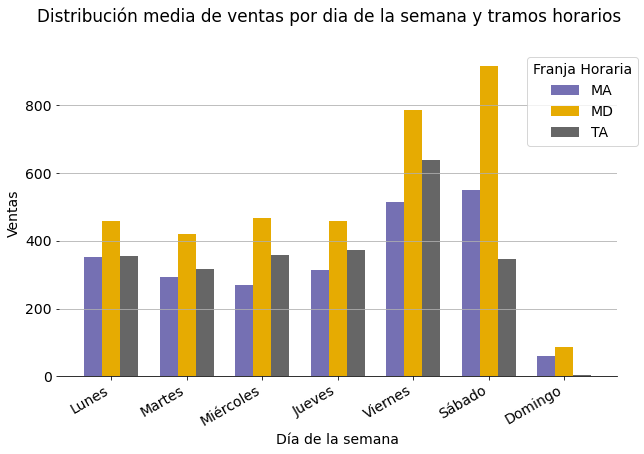

In [39]:
grouped_bar_plot(
    beer_sales_name_uniq_ticket_time_data,
    amount_key='importe',
    color_key='franja',
    group_key='numero_dia_en_semana',
    title='Distribución media de ventas por dia de la semana y tramos horarios',
    amount_title='Ventas',
    color_title='Franja Horaria',
    group_title='Día de la semana',
    rotate_x_labels=True,
    palette='Dark2',
    alternate_xlabel='nombre_dia'
    
);

* **Respuesta:** Se me ocurren tres unidades de negocio que podrían contyar con esta informació o que les sería útil:
    * La unidad Comercial: En el que tendría una información de que días y tramos horarios son los más fuertes en ventas.
    * La unidad encargada de Suplly Chain o Suministro - En el que le podría servir a nivel general que días y franjas horarias las tiendas tienen que tener más mercancia.
    * Y la tercera que se me ocurre es la de Personal o RRHH, en el que podría ver con esta gráfica cuando reforzar más el equivo de ventas de las tiendas y reponedores y cuando podría gestionar los descandos por necesitar menos personal.

### ¿Qué usos de Machine Learning verías aplicables a este conjunto de datos? ¿Podrías usar uno de esos modelos de Machine Learning para predecir la venta de cervezas durante la primera semana (agregado a nivel día) de Julio de 2018?

* **Respuesta:** Los modelos de ML que se podrían aplicar para el requerimiento de previsión de ventas para la primera semana de Julio, en principio se podrían usar **modelos como el ARIMA, SARIMA o Faceebook Prophet. También podemos usar algoritmos como la Regresión Lineal, SVM, o incluso Redes Neuronales como Perceptron Mulicapa o Recurrentes en concreto LSTM**

#### Prophet

In [40]:
beer_sales_name_uniq_ticket_time_ML_data=beer_sales_name_uniq_ticket_data.groupby(['dia','hora'],as_index=False)['importe'].sum()

beer_sales_name_uniq_ticket_time_ML_data['fecha']=pd.to_datetime(dict(year='2018', month='06', 
                                                                    day=beer_sales_name_uniq_ticket_time_ML_data['dia'],
                                                                    hour=beer_sales_name_uniq_ticket_time_ML_data['hora'],
                                                                    minute='0'))
beer_sales_name_uniq_ticket_time_ML_data=beer_sales_name_uniq_ticket_time_ML_data.loc[:,['fecha','importe']].reset_index()
# beer_sales_name_uniq_ticket_time_ML_data.set_index=beer_sales_name_uniq_ticket_time_ML_data.loc['fecha']
beer_sales_name_uniq_ticket_time_ML_data.index=pd.to_datetime(beer_sales_name_uniq_ticket_time_ML_data.fecha)
beer_sales_name_uniq_ticket_time_ML_data

,index,fecha,importe
fecha,,,
2018-06-01 10:00:00,0,2018-06-01 10:00:00,708.08
2018-06-01 11:00:00,1,2018-06-01 11:00:00,746.04
2018-06-01 12:00:00,2,2018-06-01 12:00:00,688.73
2018-06-01 13:00:00,3,2018-06-01 13:00:00,619.52
2018-06-01 14:00:00,4,2018-06-01 14:00:00,474.97
...,...,...,...
2018-06-09 19:00:00,386,2018-06-09 19:00:00,503.20
2018-06-09 20:00:00,387,2018-06-09 20:00:00,566.28
2018-06-09 21:00:00,388,2018-06-09 21:00:00,126.21


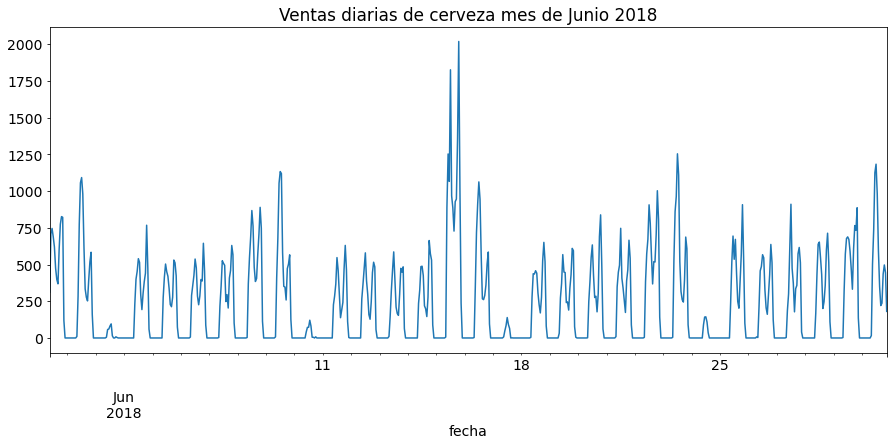

In [41]:
ventas_data = beer_sales_name_uniq_ticket_time_ML_data['importe'].resample('H').sum()
ventas_data = ventas_data.fillna(ventas_data.bfill())
ventas_data.plot(figsize=(15, 6),title='Ventas diarias de cerveza mes de Junio 2018')
plt.show()

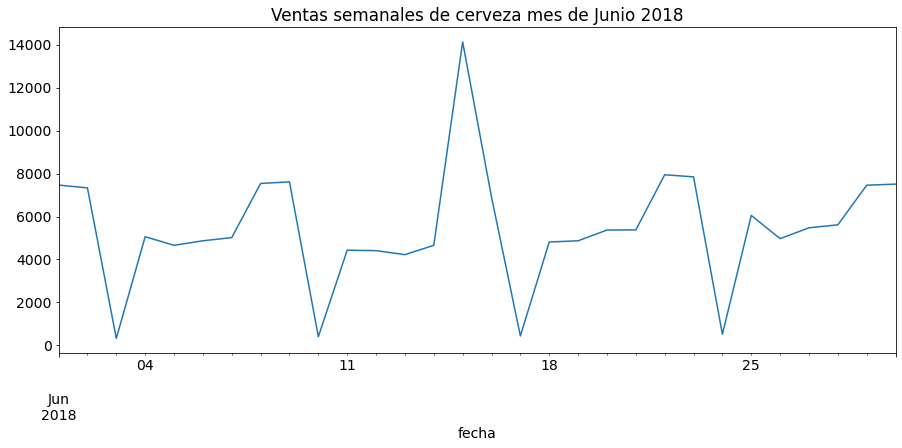

In [42]:
ventas_data = beer_sales_name_uniq_ticket_time_ML_data['importe'].resample('D').sum()
ventas_data = ventas_data.fillna(ventas_data.bfill())
ventas_data.plot(figsize=(15, 6),title='Ventas semanales de cerveza mes de Junio 2018')
plt.show()

* Observando las gráficas vemos que hay bastante estcionalidad tanto diaria, en las distintas franjas del día, como semanales repitiendose los picos de ventas los viernes y sábado. Todo esto se rompe un poco a mediados de mes que hay una incremento extraordinario.

In [43]:
ventas_data=ventas_data.reset_index(inplace=False).rename(columns={'fecha': 'ds', 'importe': 'y'})
ventas_data

,ds,y
0,2018-06-01,7466.11
1,2018-06-02,7334.45
2,2018-06-03,326.88
3,2018-06-04,5061.06
4,2018-06-05,4660.90
5,2018-06-06,4870.50
6,2018-06-07,5019.60
7,2018-06-08,7541.10
8,2018-06-09,7614.46
9,2018-06-10,405.90


In [44]:
modelo_ph = Prophet()
modelo_ph.fit(ventas_data)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.


In [45]:
# Generamos los periodos para los que queremos hacer la previsión. En este caso 7 días, que corresponde a la semana primera
# de Julio de 2018
ventas_futuro_data = modelo_ph.make_future_dataframe(periods=7, freq='d')

In [46]:
ventas_futuro_data.tail(10)

,ds
27,2018-06-28
28,2018-06-29
29,2018-06-30
30,2018-07-01
31,2018-07-02
32,2018-07-03
33,2018-07-04
34,2018-07-05
35,2018-07-06
36,2018-07-07


In [47]:
#Se realiza la predicción.
ventas_prevision_data = modelo_ph.predict(ventas_futuro_data)

In [48]:
ventas_prevision_data.tail(7)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
30,2018-07-01,5566.587752,-641.044785,2300.848033,5566.587749,5566.587755,-4782.813238,-4782.813238,-4782.813238,-4782.813238,-4782.813238,-4782.813238,0.0,0.0,0.0,783.774513
31,2018-07-02,5586.891330,4021.721138,6796.109086,5586.891321,5586.891340,-138.712116,-138.712116,-138.712116,-138.712116,-138.712116,-138.712116,0.0,0.0,0.0,5448.179214
32,2018-07-03,5607.194907,3620.822176,6470.339204,5607.194889,5607.194927,-520.511936,-520.511936,-520.511936,-520.511936,-520.511936,-520.511936,0.0,0.0,0.0,5086.682971
33,2018-07-04,5627.498485,3924.489405,6796.789086,5627.498454,5627.498516,-284.129711,-284.129711,-284.129711,-284.129711,-284.129711,-284.129711,0.0,0.0,0.0,5343.368774
34,2018-07-05,5647.802063,4153.306541,7028.880148,5647.802016,5647.802108,-121.892053,-121.892053,-121.892053,-121.892053,-121.892053,-121.892053,0.0,0.0,0.0,5525.910010
35,2018-07-06,5668.105641,7930.452785,10711.591569,5668.105578,5668.105701,3666.796487,3666.796487,3666.796487,3666.796487,3666.796487,3666.796487,0.0,0.0,0.0,9334.902128
36,2018-07-07,5688.409219,6418.297073,9375.516587,5688.409141,5688.409295,2181.262567,2181.262567,2181.262567,2181.262567,2181.262567,2181.262567,0.0,0.0,0.0,7869.671786


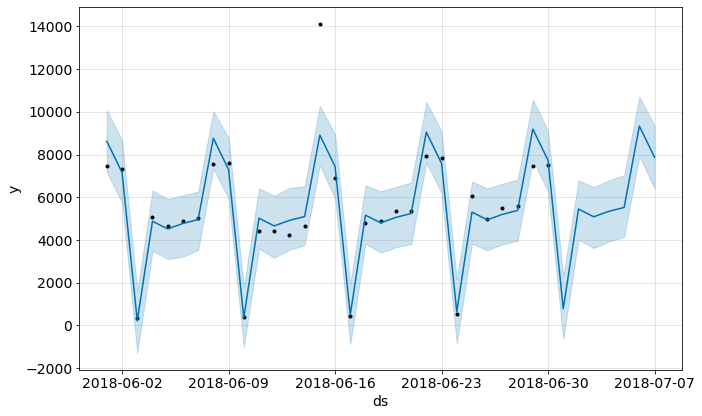

In [49]:
#Ploteamos los datos de la previsión.
# Se observa la misma tendencia levemente de incremento y  de ventas con la misma 
modelo_ph.plot(ventas_prevision_data);

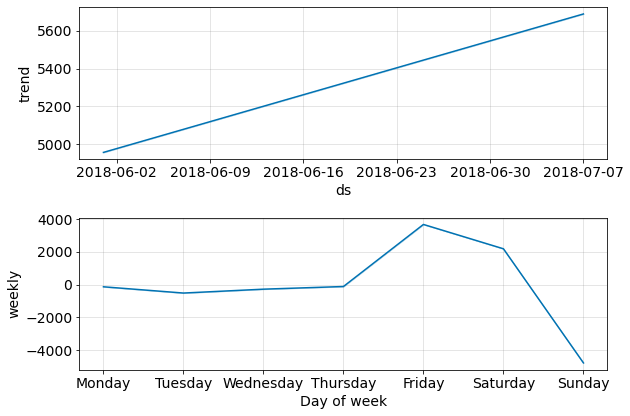

In [50]:
# modelo_ph.plot_components(ventas_prevision_data);
modelo_ph.plot_components(ventas_prevision_data, weekly_start = 1);

In [51]:
#Seleccionamos los datos del 1 de Julio al 7 de Julio de 2018
ventas_prevision_data_julio_2018=ventas_prevision_data[((ventas_prevision_data['ds'] >= '2018-07-01') &
    (ventas_prevision_data['ds'] <= '2018-07-07'))].loc[:,['ds','yhat']]
#Mostramos la previsión de Ventas para la primera semana de Julio.
ventas_prevision_data_julio_2018 = ventas_prevision_data_julio_2018.rename(columns={'ds': 'Fecha', 'yhat': 'Ventas'})
ventas_prevision_data_julio_2018

,Fecha,Ventas
30,2018-07-01,783.774513
31,2018-07-02,5448.179214
32,2018-07-03,5086.682971
33,2018-07-04,5343.368774
34,2018-07-05,5525.910010
35,2018-07-06,9334.902128
36,2018-07-07,7869.671786


* Para afinar más las predicciones Prophet permite establecimiento de fechas singulares, periodos vacacionales y demás, que pueden hacer explicar los outliers o anomalias que pudieran existir en las series temporales.

#### Modelos ML Regresores

In [52]:
ventas_data_regresor = beer_sales_name_uniq_ticket_time_ML_data['importe'].resample('D').sum()
ventas_data_regresor = ventas_data_regresor.fillna(ventas_data_regresor.bfill())
ventas_data_regresor

fecha
2018-06-01     7466.11
2018-06-02     7334.45
2018-06-03      326.88
2018-06-04     5061.06
2018-06-05     4660.90
2018-06-06     4870.50
2018-06-07     5019.60
2018-06-08     7541.10
2018-06-09     7614.46
2018-06-10      405.90
2018-06-11     4433.93
2018-06-12     4412.02
2018-06-13     4224.72
2018-06-14     4660.73
2018-06-15    14133.90
2018-06-16     6906.28
2018-06-17      438.12
2018-06-18     4814.43
2018-06-19     4871.02
2018-06-20     5371.59
2018-06-21     5377.65
2018-06-22     7945.17
2018-06-23     7847.87
2018-06-24      518.57
2018-06-25     6052.20
2018-06-26     4970.52
2018-06-27     5475.15
2018-06-28     5614.67
2018-06-29     7460.14
2018-06-30     7510.71
Freq: D, Name: importe, dtype: float64

In [53]:
ventas_data_regresor=ventas_data_regresor.reset_index()
ventas_data_regresor

,fecha,importe
0,2018-06-01,7466.11
1,2018-06-02,7334.45
2,2018-06-03,326.88
3,2018-06-04,5061.06
4,2018-06-05,4660.90
5,2018-06-06,4870.50
6,2018-06-07,5019.60
7,2018-06-08,7541.10
8,2018-06-09,7614.46
9,2018-06-10,405.90


In [54]:
ventas_data_regresor['OffsetDays'] = ventas_data_regresor.index
ventas_data_regresor

,fecha,importe,OffsetDays
0,2018-06-01,7466.11,0
1,2018-06-02,7334.45,1
2,2018-06-03,326.88,2
3,2018-06-04,5061.06,3
4,2018-06-05,4660.90,4
5,2018-06-06,4870.50,5
6,2018-06-07,5019.60,6
7,2018-06-08,7541.10,7
8,2018-06-09,7614.46,8
9,2018-06-10,405.90,9


In [55]:
#Generamos variables sinteticas para tener más datos y poder afinar más la predicción.
#Dia de la semana.

ventas_data_regresor_2 = ventas_data_regresor.copy()
ventas_data_regresor_2['dia_semana'] = ventas_data_regresor_2['fecha'].dt.dayofweek
ventas_data_regresor_2=pd.get_dummies(ventas_data_regresor_2,columns=['dia_semana'])
ventas_data_regresor_2=ventas_data_regresor_2.dropna()
ventas_data_regresor_2

,fecha,importe,OffsetDays,dia_semana_0,dia_semana_1,dia_semana_2,dia_semana_3,dia_semana_4,dia_semana_5,dia_semana_6
0,2018-06-01,7466.11,0,0,0,0,0,1,0,0
1,2018-06-02,7334.45,1,0,0,0,0,0,1,0
2,2018-06-03,326.88,2,0,0,0,0,0,0,1
3,2018-06-04,5061.06,3,1,0,0,0,0,0,0
4,2018-06-05,4660.90,4,0,1,0,0,0,0,0
5,2018-06-06,4870.50,5,0,0,1,0,0,0,0
6,2018-06-07,5019.60,6,0,0,0,1,0,0,0
7,2018-06-08,7541.10,7,0,0,0,0,1,0,0
8,2018-06-09,7614.46,8,0,0,0,0,0,1,0
9,2018-06-10,405.90,9,0,0,0,0,0,0,1


In [56]:
# La segunda técnica que vamos a utilizar es generación de variables sintecticas con las técnicas de lags y diferencias.
# Como observamos ciertas periodicidades semanales, calculamos la diferecnia de ventas del día anterior y los 7 anteriores
ventas_data_regresor_2['importe_dif_prev1'] = ventas_data_regresor_2['importe'].diff(1)
ventas_data_regresor_2['importe_dif_prev2'] = ventas_data_regresor_2['importe'].diff(2)
ventas_data_regresor_2['importe_dif_prev3'] = ventas_data_regresor_2['importe'].diff(3)
ventas_data_regresor_2['importe_dif_prev4'] = ventas_data_regresor_2['importe'].diff(4)
ventas_data_regresor_2['importe_dif_prev5'] = ventas_data_regresor_2['importe'].diff(5)
ventas_data_regresor_2['importe_dif_prev6'] = ventas_data_regresor_2['importe'].diff(6)
ventas_data_regresor_2['importe_dif_prev7'] = ventas_data_regresor_2['importe'].diff(7)
ventas_data_regresor_2=ventas_data_regresor_2.dropna()
ventas_data_regresor_2

,fecha,importe,OffsetDays,dia_semana_0,dia_semana_1,dia_semana_2,dia_semana_3,dia_semana_4,dia_semana_5,dia_semana_6,importe_dif_prev1,importe_dif_prev2,importe_dif_prev3,importe_dif_prev4,importe_dif_prev5,importe_dif_prev6,importe_dif_prev7
7,2018-06-08,7541.10,7,0,0,0,0,1,0,0,2521.50,2670.60,2880.20,2480.04,7214.22,206.65,74.99
8,2018-06-09,7614.46,8,0,0,0,0,0,1,0,73.36,2594.86,2743.96,2953.56,2553.40,7287.58,280.01
9,2018-06-10,405.90,9,0,0,0,0,0,0,1,-7208.56,-7135.20,-4613.70,-4464.60,-4255.00,-4655.16,79.02
10,2018-06-11,4433.93,10,1,0,0,0,0,0,0,4028.03,-3180.53,-3107.17,-585.67,-436.57,-226.97,-627.13
11,2018-06-12,4412.02,11,0,1,0,0,0,0,0,-21.91,4006.12,-3202.44,-3129.08,-607.58,-458.48,-248.88
12,2018-06-13,4224.72,12,0,0,1,0,0,0,0,-187.30,-209.21,3818.82,-3389.74,-3316.38,-794.88,-645.78
13,2018-06-14,4660.73,13,0,0,0,1,0,0,0,436.01,248.71,226.80,4254.83,-2953.73,-2880.37,-358.87
14,2018-06-15,14133.90,14,0,0,0,0,1,0,0,9473.17,9909.18,9721.88,9699.97,13728.00,6519.44,6592.80
15,2018-06-16,6906.28,15,0,0,0,0,0,1,0,-7227.62,2245.55,2681.56,2494.26,2472.35,6500.38,-708.18
16,2018-06-17,438.12,16,0,0,0,0,0,0,1,-6468.16,-13695.78,-4222.61,-3786.60,-3973.90,-3995.81,32.22


In [57]:
ventas_data_regresor_2.pop('fecha')
ventas_data_regresor_2

,importe,OffsetDays,dia_semana_0,dia_semana_1,dia_semana_2,dia_semana_3,dia_semana_4,dia_semana_5,dia_semana_6,importe_dif_prev1,importe_dif_prev2,importe_dif_prev3,importe_dif_prev4,importe_dif_prev5,importe_dif_prev6,importe_dif_prev7
7,7541.10,7,0,0,0,0,1,0,0,2521.50,2670.60,2880.20,2480.04,7214.22,206.65,74.99
8,7614.46,8,0,0,0,0,0,1,0,73.36,2594.86,2743.96,2953.56,2553.40,7287.58,280.01
9,405.90,9,0,0,0,0,0,0,1,-7208.56,-7135.20,-4613.70,-4464.60,-4255.00,-4655.16,79.02
10,4433.93,10,1,0,0,0,0,0,0,4028.03,-3180.53,-3107.17,-585.67,-436.57,-226.97,-627.13
11,4412.02,11,0,1,0,0,0,0,0,-21.91,4006.12,-3202.44,-3129.08,-607.58,-458.48,-248.88
12,4224.72,12,0,0,1,0,0,0,0,-187.30,-209.21,3818.82,-3389.74,-3316.38,-794.88,-645.78
13,4660.73,13,0,0,0,1,0,0,0,436.01,248.71,226.80,4254.83,-2953.73,-2880.37,-358.87
14,14133.90,14,0,0,0,0,1,0,0,9473.17,9909.18,9721.88,9699.97,13728.00,6519.44,6592.80
15,6906.28,15,0,0,0,0,0,1,0,-7227.62,2245.55,2681.56,2494.26,2472.35,6500.38,-708.18
16,438.12,16,0,0,0,0,0,0,1,-6468.16,-13695.78,-4222.61,-3786.60,-3973.90,-3995.81,32.22


In [58]:
from sklearn.svm import SVR
# Selección de los modelos

# Creamos una lista con los distintos modelos que queremos utilizar
# Como esta parte es sin ajustar parámetros los ejecutamos con los que vengan por defecto.
models = []
models.append(('SVM', SVR(kernel='rbf', C=10))) # Máquina Vector Soporte
#{'C': 10, 'kernel': 'rbf'}

models.append(('GBR', GradientBoostingRegressor(learning_rate=0.01,max_depth=4,n_estimators=100,random_state=42))) #GBoostingRegresor
#{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100, 'random_state': 42}

models.append(('RFR', RandomForestRegressor(max_depth=5, min_samples_split=10,n_estimators=500,random_state=42))) #RandomForest
# {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 500, 'random_state': 42}

models.append(('KNR', KNeighborsRegressor(n_neighbors=3,p=1,weights='uniform'))) #KNR
# {'n_neighbors': 19, 'p': 1, 'weights': 'uniform'}

In [59]:
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))


def calculoEvaluacionModelo(modelo,df,norm):

    xPredicted = []
    yPredicted = []
    ySpotted = []
    mean_error = []

    for day in range(14,30):#Modificar este data range en función de la longitud final del dataframe que nos salga y necesitemos para la prevsion
        train = df[df['OffsetDays'] < day]
        val = df[df['OffsetDays'] == day]       
        
        xtr, xts = train.drop(['importe'], axis=1), val.drop(['importe'], axis=1)
       
        
        if(norm==True):
            sc = StandardScaler()  
            xtr = sc.fit_transform(xtr)  
            xts = sc.transform(xts)  
        ytr, yts = train['importe'].values, val['importe'].values  

        mdl = modelo
        mdl.fit(xtr, ytr)

        p = mdl.predict(xts)

        xPredicted=xPredicted + [day]
        yPredicted=yPredicted + [p[0]]
        ySpotted = ySpotted + [yts[0]]

        error = rmsle(yts, p)
#         print('Month %d - Error %.5f' % (day, error))
        mean_error.append(error)

    print('Mean Error = %.5f' % np.mean(mean_error))
    prediction = pd.DataFrame(
        {'Predicción del Importe de Ventas': yPredicted,
         'Importe de Ventas Reales': ySpotted
        },index=xPredicted)
    prediction.plot()
    plt.show();

Predicción Modelo :SVM
Mean Error = 0.53797


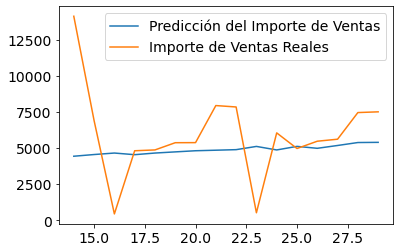

Predicción Modelo :GBR
Mean Error = 0.37140


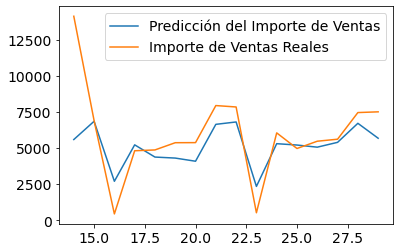

Predicción Modelo :RFR
Mean Error = 0.45536


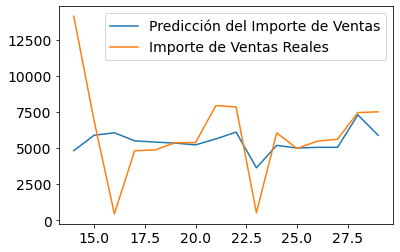

Predicción Modelo :KNR
Mean Error = 0.32638


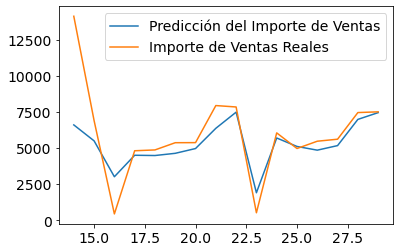

In [60]:
for index,model in enumerate(models):
    print('Predicción Modelo :'+model[0])
    calculoEvaluacionModelo(model[1],ventas_data_regresor_2,norm=True)

* Como observamos y con los parámetros iniciales con los que los hemos creado, el **GradientBoostingRegressor y el KNeighborsRegressor**, son los mejores en predicción. Si se quieren optimizar habría que lanzar GridSearchCV, para los modelos elegidos y así encontra la mejor combinación de parámetros. También se podría haber montado con la red básica que nos proporciona la librería sklearn, el MLP, Percetron Multicapa, pero se demora bastante en el entreno.

### PARTE DESCRIPTIVA: 
Si estuviesemos interesados en hacer una segmentación de los tickets anteriores en buscar de obtener las misiones de compra (los distintos motivos por los que los clientes van a comprar las cervezas), en base a la información disponible en los ficheros ¿Qué variables crees que se podrían incorporar al modelo, cuáles construirías nuevas a partir de la información disponible y que transformaciones aplicarías sobre ellas antes de entrenar el modelo?

* **Respuesta:** Entendiendo que la segmentación de los tickets se haga por un proceso de clasterización, bien usando el habitual KMeans o tal vez DBSCAN, previa reducción o no de caracteristicas usando PCA, las variables que a mi juicio sería importante incorporar al modelo podrían ser:
    * **Año y mes:** Indispensables para saber ciertas estacionalidades y saber si corresponden a meses de Primavera\Verano donde presumiblemente se vende más cerveza. Una vez que se tuvieran habría que hacer dummie variables a partir de ellas.
    * **Día_de_la_semana:** Viendo como se comportan las ventas parece que hay mayor propensión a compra los viernes, sábado. Esta variables se podía sacar tal como lo he realizado en apartados anteriores, calculando la fecha, apartir del día, hora, minuto. También habría que añadir a los datos año y mes. Exigiría posteriormente un proceso dummie variable.
    * **Franja_Horaria:** También calculada en apartados anteriores, a partir de la hora. Se ve que las ventas aumentan, en tramos de medio día MD y TA, tarde. Habría que crear variables dummie a partir de ella.
    * **Precio\Importe:** Es una variable que puede determinar el ir a comprar cervezas. Habría normalizar el valor con un StandarScaler.
    * **Datos Socio\Economicos asociados a la situación geográfica de la tienda:** Datos como renta_per_capita, edad_media de los residentes en la zona de la tienda, serín importantes para saber algo sobre las misiones de compra. Tal vez gente de rentas, medias-bajas, y barrios con gente joven influyen en comprar más cerveza. Todos estos datos al ser numéricos habría que normalizarlos previa incorporación al modelo.
        
        